In [6]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Ensure repo root is in the Python path (go up two levels from 'common_src/development')
repo_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if repo_root not in sys.path:
    sys.path.append(repo_root)

print("Using repo root:", repo_root)

Using repo root: /home/lleba/final_assignment


In [7]:
from common_src.dataset.view_of_delft import ViewOfDelft

dataset = ViewOfDelft(
    data_root=os.path.join(repo_root, 'data/view_of_delft'),
    split='train'
)

sample = dataset[0]

lidar = sample['lidar_data'].numpy()
labels = sample['gt_labels_3d']
bboxes = sample['gt_bboxes_3d']
meta = sample['meta']

print("LiDAR shape:", lidar.shape)
print("Number of ground-truth objects:", len(labels))
print("Sample index:", meta['num_frame'])


LiDAR shape: (169884, 6)
Number of ground-truth objects: 6
Sample index: 00544


In [47]:
from vod.frame import FrameDataLoader, FrameTransformMatrix, homogeneous_transformation
from vod.configuration import KittiLocations
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
import torchvision.transforms as T
import torch.nn.functional as F

# Reload the same frame to access RGB
frame_id = meta['num_frame']
vod = FrameDataLoader(KittiLocations(os.path.join(repo_root, 'data/view_of_delft')), frame_number=frame_id)
transforms = FrameTransformMatrix(vod)
rgb = vod.image
H, W, _ = rgb.shape

# DeepLabV3 model
seg_model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT).eval()
img_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(520),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# Apply segmentation
input_tensor = img_transform(rgb).unsqueeze(0)
with torch.inference_mode():
    seg_output = seg_model(input_tensor)['out']
    seg_map = seg_output.argmax(1).squeeze(0)  # [H', W'] with class indices


Sample semantic probabilities per painted LiDAR point:
Point 0: [0. 0. 0.]
Point 1: [0. 0. 0.]
Point 2: [0. 0. 0.]
Point 3: [0. 0. 0.]
Point 4: [0.    0.    0.401]
Point 5: [0. 0. 0.]
Point 6: [0.   0.   0.14]
Point 7: [0. 0. 0.]
Point 8: [0. 0. 0.]
Point 9: [0.    0.    0.008]


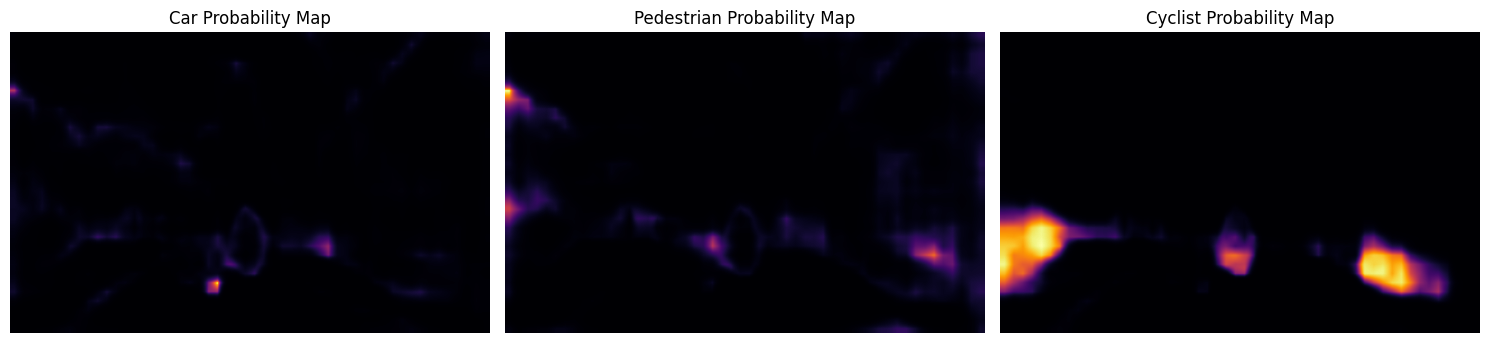

In [48]:
# Step 1: Project LiDAR points to image
xyz = torch.tensor(lidar[:, :3], dtype=torch.float32)
xyz_hom = torch.cat([xyz, torch.ones((xyz.shape[0], 1), device=xyz.device)], dim=1)
xyz_cam = torch.tensor(
    homogeneous_transformation(xyz_hom.cpu().numpy(), transforms.t_camera_lidar),
    device=xyz.device
)
proj = xyz_cam @ torch.tensor(transforms.camera_projection_matrix.T, device=xyz.device, dtype=xyz_cam.dtype)

# Step 2: Compute UV and valid mask
uv = proj[:, :2] / proj[:, 2:3]
uv_int = uv.round().long()
H, W, _ = rgb.shape
uv_int[:, 0] = uv_int[:, 0].clamp(0, W - 1)
uv_int[:, 1] = uv_int[:, 1].clamp(0, H - 1)
valid = proj[:, 2] > 0

# Step 3: Apply valid mask to UV and xyz
uv_int_valid = uv_int[valid]
u, v = uv_int_valid[:, 0], uv_int_valid[:, 1]
xyz_valid = xyz[valid]

# Step 4: Resize DeepLab output
seg_logits = seg_output.squeeze(0)
seg_probs = F.softmax(seg_logits, dim=0)
seg_probs_resized = F.interpolate(seg_probs.unsqueeze(0), size=(H, W), mode='bilinear', align_corners=False).squeeze(0)

# Step 5: Extract 3 semantic classes
bike_prob = (seg_probs_resized[2] + seg_probs_resized[4]) / 2
semantic_features = torch.stack([
    seg_probs_resized[3],  # car
    seg_probs_resized[1],  # person
    bike_prob              # cyclist
], dim=0)

# Step 6: Sample features and concatenate
semantic_feats = semantic_features[:, v, u].T
painted_pts = torch.cat([xyz_valid, semantic_feats.to(xyz.device)], dim=1)

print("Sample semantic probabilities per painted LiDAR point:")
for i in range(min(10, semantic_feats.shape[0])):
    print(f"Point {i}: {semantic_feats[i].cpu().numpy().round(3)}")

# Step 7: Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = ['Car', 'Pedestrian', 'Cyclist']
for i in range(3):
    axs[i].imshow(semantic_features[i].cpu(), cmap='inferno')
    axs[i].set_title(f"{labels[i]} Probability Map")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


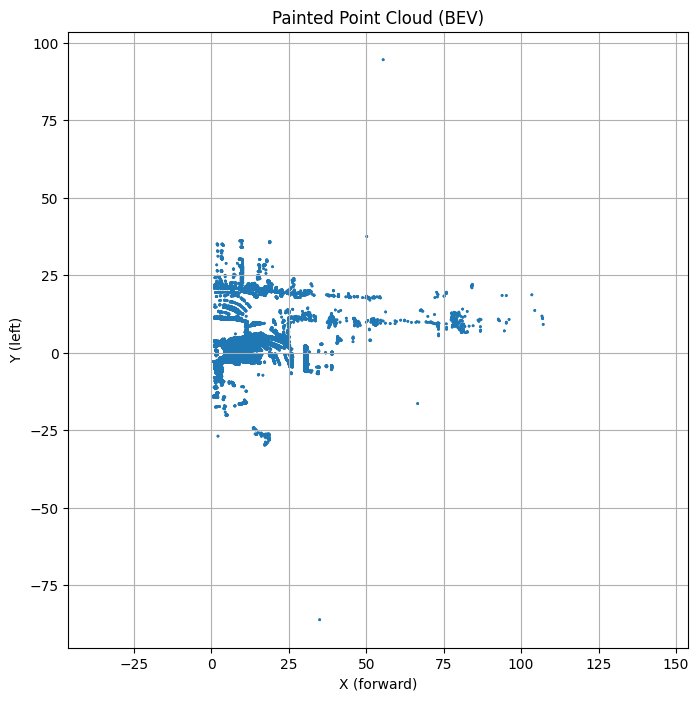

In [49]:
# Compute predicted semantic class (0 = Car, 1 = Pedestrian, 2 = Cyclist)
semantic_probs = painted_pts[:, 3:]  # shape [N, 3]
painted_classes = torch.argmax(semantic_probs, dim=1).numpy()


plt.figure(figsize=(8, 8))
plt.scatter(painted_pts[:, 0], painted_pts[:, 1], c=painted_classes, cmap='tab20', s=1)
plt.title("Painted Point Cloud (BEV)")
plt.xlabel("X (forward)")
plt.ylabel("Y (left)")
plt.axis("equal")
plt.grid(True)
plt.show()

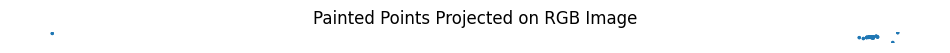

In [50]:
plt.figure(figsize=(12, 8))
plt.imshow(rgb)
plt.scatter(uv[valid][:, 0], uv[valid][:, 1], c=painted_classes, cmap='tab20', s=2)
plt.title("Painted Points Projected on RGB Image")
plt.axis('off')
plt.show()



In [51]:
# Assume painted_pts.shape = [N, 6]
semantic_probs = painted_pts[:, 3:]  # shape [N, 3]

# Define class names
class_names = ['Car', 'Pedestrian', 'Cyclist']
threshold = 1e-3  # minimum total confidence

# Print a few example points with safety check
for i in range(min(5, painted_pts.shape[0])):
    xyz = painted_pts[i, :3].cpu().numpy()
    probs = painted_pts[i, 3:].cpu().numpy()

    if probs.sum() < threshold:
        cls = "Uncertain / background"
    else:
        cls = class_names[probs.argmax()]

    print(f"Point {i} | XYZ: {xyz} | Probs: {probs.round(3)} | Predicted: {cls}")


Point 0 | XYZ: [ 1.3486271   2.4114408  -0.14264062] | Probs: [0. 0. 0.] | Predicted: Uncertain / background
Point 1 | XYZ: [ 1.3059545  2.3965085 -0.1312475] | Probs: [0. 0. 0.] | Predicted: Uncertain / background
Point 2 | XYZ: [ 1.164155    2.446441   -0.11882777] | Probs: [0. 0. 0.] | Predicted: Uncertain / background
Point 3 | XYZ: [ 1.1267924   2.3433945  -0.09295814] | Probs: [0. 0. 0.] | Predicted: Uncertain / background
Point 4 | XYZ: [ 3.508116  20.91606   -0.8983473] | Probs: [0.    0.    0.401] | Predicted: Cyclist


In [8]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
from vod.frame import FrameDataLoader, FrameTransformMatrix, homogeneous_transformation
from vod.configuration import KittiLocations
from common_src.dataset.view_of_delft import ViewOfDelft

In [9]:
# Set up paths and load a frame
repo_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if repo_root not in sys.path:
    sys.path.append(repo_root)

dataset = ViewOfDelft(data_root=os.path.join(repo_root, 'data/view_of_delft'), split='train')
sample = dataset[0]
lidar = sample['lidar_data'].numpy()
meta = sample['meta']

# RGB and transforms
frame_id = meta['num_frame']
vod = FrameDataLoader(KittiLocations(os.path.join(repo_root, 'data/view_of_delft')), frame_number=frame_id)
transforms = FrameTransformMatrix(vod)
rgb = vod.image
H, W, _ = rgb.shape

# Segmentation
model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT).eval()
transform = T.Compose([
    T.ToPILImage(),
    T.Resize(520),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(rgb).unsqueeze(0)
with torch.inference_mode():
    seg_output = model(input_tensor)['out']

In [10]:
# Step 1: Project LiDAR points to image
xyz = torch.tensor(lidar[:, :3], dtype=torch.float32)
xyz_hom = torch.cat([xyz, torch.ones((xyz.shape[0], 1))], dim=1)
xyz_cam = torch.tensor(homogeneous_transformation(xyz_hom.numpy(), transforms.t_camera_lidar))
proj = xyz_cam @ torch.tensor(transforms.camera_projection_matrix.T, dtype=xyz_cam.dtype)
uv = proj[:, :2] / proj[:, 2:3]

# Step 2: Scale UV coordinates to DeepLab input resolution (520×520)
resized_H, resized_W = 520, 520
uv_scaled = uv.clone()
uv_scaled[:, 0] *= resized_W / W
uv_scaled[:, 1] *= resized_H / H

# Step 3: Clamp and create valid mask
uv_int = uv_scaled.round().long()
uv_int[:, 0] = uv_int[:, 0].clamp(0, resized_W - 1)
uv_int[:, 1] = uv_int[:, 1].clamp(0, resized_H - 1)
valid = proj[:, 2] > 0

# Step 4: Apply valid mask to projected points and UVs
uv_int_valid = uv_int[valid]
u = uv_int_valid[:, 0]
v = uv_int_valid[:, 1]
xyz_valid = xyz[valid]

# Step 5: Use raw DeepLab output (no resize needed)
seg_logits = seg_output.squeeze(0)           # shape: [21, 520, 520]
seg_probs = F.softmax(seg_logits, dim=0)     # shape: [21, 520, 520]

# Step 6: Extract semantic class probabilities
bike_prob = (seg_probs[2] + seg_probs[4]) / 2
semantic_features = torch.stack([
    seg_probs[3],  # Car
    seg_probs[1],  # Pedestrian
    bike_prob      # Cyclist
], dim=0)  # shape: [3, 520, 520]

# Step 7: Sample semantic features and concatenate
semantic_feats = semantic_features[:, v, u].T  # [N_valid, 3]
painted_pts = torch.cat([xyz_valid, semantic_feats], dim=1)  # [N_valid, 6]
painted_classes = torch.argmax(semantic_feats, dim=1)


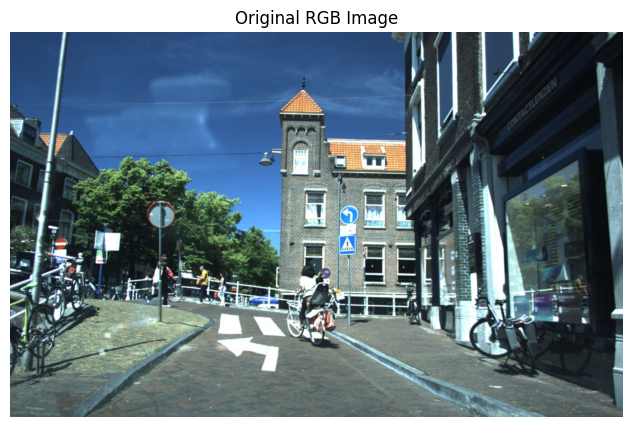

In [11]:
# 1. Show original RGB
plt.figure(figsize=(10, 5))
plt.imshow(rgb)
plt.title("Original RGB Image")
plt.axis('off')
plt.show()

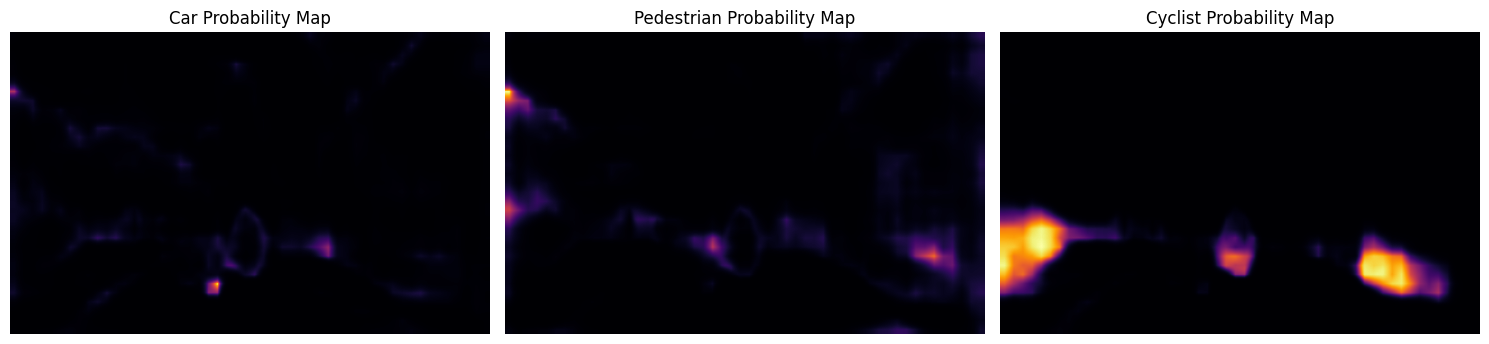

In [12]:
# 2. Segmentation Probabilities
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = ['Car', 'Pedestrian', 'Cyclist']
for i in range(3):
    axs[i].imshow(semantic_features[i].cpu(), cmap='inferno')
    axs[i].set_title(f"{labels[i]} Probability Map")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

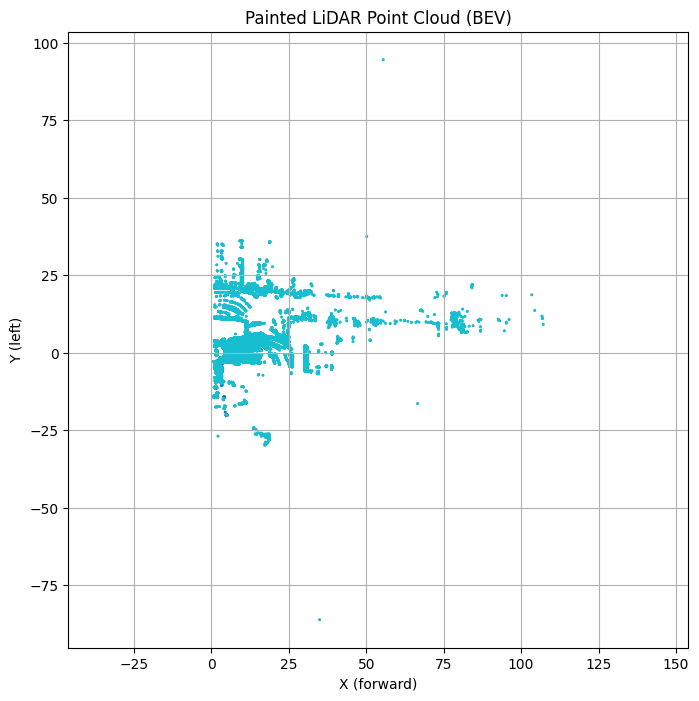

In [13]:
# 3. Painted Point Cloud (BEV)
plt.figure(figsize=(8, 8))
plt.scatter(painted_pts[:, 0], painted_pts[:, 1], c=painted_classes, cmap='tab10', s=1)
plt.title("Painted LiDAR Point Cloud (BEV)")
plt.xlabel("X (forward)")
plt.ylabel("Y (left)")
plt.axis("equal")
plt.grid(True)
plt.show()


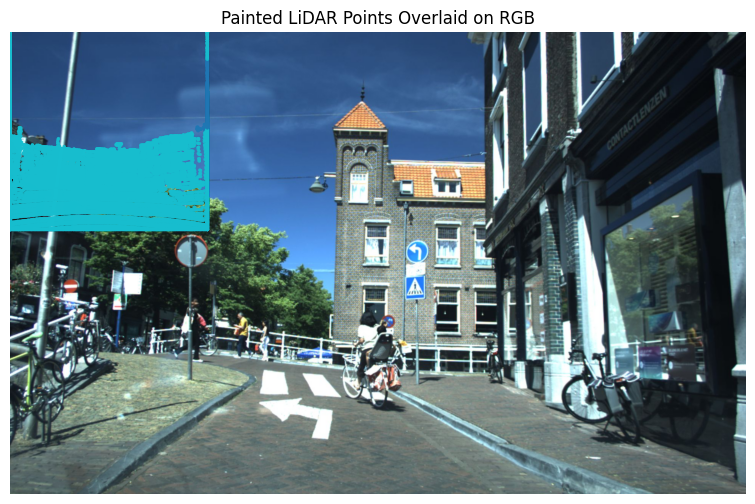

In [14]:
# 4. Painted Points on RGB
plt.figure(figsize=(12, 6))
plt.imshow(rgb)
plt.scatter(u.cpu(), v.cpu(), c=painted_classes, cmap='tab10', s=2, alpha=0.6)
plt.title("Painted LiDAR Points Overlaid on RGB")
plt.axis('off')
plt.show()

In [15]:
print("Unique predicted classes:", torch.unique(painted_classes))

Unique predicted classes: tensor([0, 2])


In [16]:
# Print semantic probabilities for a few points
print("Sample semantic probabilities per point:")
for i in range(min(10, painted_pts.shape[0])):
    xyz_pt = painted_pts[i, :3].numpy().round(2)
    probs = painted_pts[i, 3:].numpy().round(3)
    pred = ['Car', 'Pedestrian', 'Cyclist'][painted_classes[i]]
    print(f"Point {i}: XYZ={xyz_pt} | Probs={probs} | Predicted={pred}")


Sample semantic probabilities per point:
Point 0: XYZ=[ 1.35  2.41 -0.14] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 1: XYZ=[ 1.31  2.4  -0.13] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 2: XYZ=[ 1.16  2.45 -0.12] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 3: XYZ=[ 1.13  2.34 -0.09] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 4: XYZ=[ 3.51 20.92 -0.9 ] | Probs=[0.  0.  0.4] | Predicted=Cyclist
Point 5: XYZ=[ 2.07 11.36 -0.34] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 6: XYZ=[ 2.61 11.17 -0.77] | Probs=[0.    0.    0.122] | Predicted=Cyclist
Point 7: XYZ=[ 1.6  11.13 -0.25] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 8: XYZ=[ 1.15 21.31 -0.58] | Probs=[0. 0. 0.] | Predicted=Cyclist
Point 9: XYZ=[ 1.76 11.22 -0.65] | Probs=[0.    0.    0.008] | Predicted=Cyclist


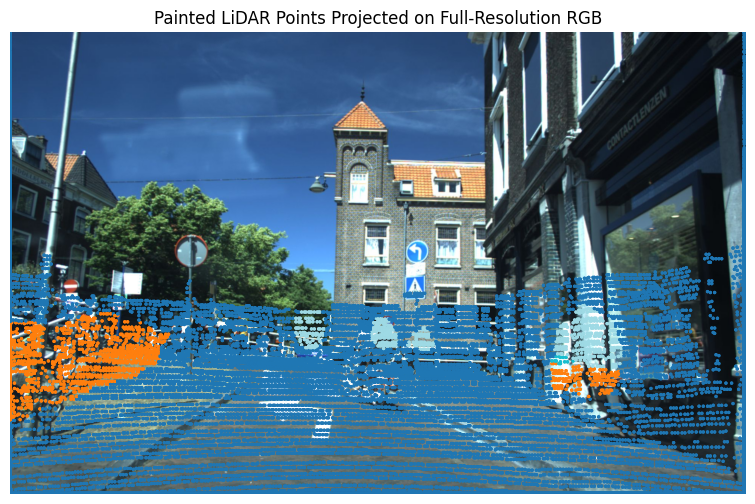

Unique predicted COCO classes:
Class 0: background
Class 2: bicycle
Class 14: bench
Class 15: bird


In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Step 1: DeepLab output (21 classes)
seg_logits = seg_output.squeeze(0)            # [21, 520, 520]
seg_probs = F.softmax(seg_logits, dim=0)      # [21, 520, 520]

# Step 2: Scale UV to DeepLab input size (520×520)
resized_H, resized_W = 520, 520
uv_scaled = uv.clone()
uv_scaled[:, 0] *= resized_W / W
uv_scaled[:, 1] *= resized_H / H
uv_int = uv_scaled.round().long()
uv_int[:, 0] = uv_int[:, 0].clamp(0, resized_W - 1)
uv_int[:, 1] = uv_int[:, 1].clamp(0, resized_H - 1)
valid = proj[:, 2] > 0

# Step 3: Apply valid mask
uv_int_valid = uv_int[valid]
u = uv_int_valid[:, 0]
v = uv_int_valid[:, 1]
xyz_valid = xyz[valid]

# Step 4: Sample full 21-class semantic probabilities
semantic_feats = seg_probs[:, v, u].T  # [N_valid, 21]

# Step 5: Predicted class ID per point
painted_classes = torch.argmax(semantic_feats, dim=1)  # [N_valid]

# Step 6: Rescale UVs to original RGB size for plotting
u_rgb = (u.float() * W / resized_W).cpu()
v_rgb = (v.float() * H / resized_H).cpu()

# Step 7: Plot on original RGB image
plt.figure(figsize=(12, 6))
plt.imshow(rgb)
plt.scatter(u_rgb, v_rgb, c=painted_classes.cpu(), cmap='tab20', s=2)
plt.title("Painted LiDAR Points Projected on Full-Resolution RGB")
plt.axis('off')
plt.show()

# Step 8: Print predicted COCO class names
COCO_CLASSES = [
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'
]

unique_ids = torch.unique(painted_classes)
print("Unique predicted COCO classes:")
for idx in unique_ids:
    idx_int = idx.item()
    class_name = COCO_CLASSES[idx_int] if idx_int < len(COCO_CLASSES) else f"unknown_{idx_int}"
    print(f"Class {idx_int}: {class_name}")
